# Проект e-commerce:
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Считываем таблицу с уникальными идентификаторами пользователей
user_table = pd.read_csv('olist_customers_dataset.csv', sep=',')

**Описание файла olist_customers_datase.csv**
```
customer_id - позаказный идентификатор пользователя;
customer_unique_id - уникальный идентификатор пользователя (аналог номера паспорта);
customer_zip_code_prefix - почтовый индекс пользователя;
customer_city - город доставки пользователя;
customer_state - штат доставки пользователя.
```

In [ ]:
# Считываем таблицу с заказами
order_table = pd.read_csv('olist_orders_dataset.csv', sep=',')

**Описание файла olist_orders_dataset.csv**
```
order_id - уникальный идентификатор заказа (номер чека);
customer_id - позаказный идентификатор пользователя;
order_status - статус заказа;
order_purchase_timestamp - время создания заказа;
order_approved_at - время подтверждения оплаты заказа;
order_delivered_carrier_date - время передачи заказа в логистическую службу;
order_delivered_customer_date - время доставки заказа;
order_estimated_delivery_date - обещанная дата доставки.
```
Уникальные статусы заказов в таблице:


*   created - создан;
*   approved - подтвержден;
*   processing - в процессе сборки заказа;
*   shipped - отгружен со склада;
*   delivered - доставлен пользователю;
*   unavailable - недоступен;
*   canceled - отменен.









In [ ]:
# Считываем таблицу с товарными позициями, входящими в заказы
order_items = pd.read_csv('olist_order_items_dataset.csv', sep=',')

**Описание файла olist_order_items__dataset.csv**
```
order_id - уникальный идентификатор заказа (номер чека);
order_item_id - идентификатор товара внутри одного заказа;
product_id - ид товара (аналог штрихкода);
seller_id - ид производителя товара;
shipping_limit_date - максимальная дата доставки продавцом для предачи заказа партнеру по логистике;
price - цена за единицу товара;
freight_value - вес товара.
```

Преобразование типов:

In [ ]:
order_table['order_approved_at'] = pd.to_datetime(order_table['order_approved_at'], format='%Y-%m-%d %H:%M:%S')
order_table['order_purchase_timestamp'] = pd.to_datetime(order_table['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
order_table['order_delivered_carrier_date'] = pd.to_datetime(order_table['order_delivered_carrier_date'], format='%Y-%m-%d %H:%M:%S')
order_table['order_delivered_customer_date'] = pd.to_datetime(order_table['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
order_table['order_estimated_delivery_date '] = pd.to_datetime(order_table['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

### **1) Количество пользователей, которые совершили покупку только один раз:**
Понятием "покупка" будем считать все заказы, которые были доставлены пользователю.


In [ ]:
# Фильтруем понятие покупки по статусу заказа "доставлен":
order_table_true = order_table[order_table['order_status'] == "delivered"]

# Соединяем таблицы пользователей с таблицей заказов по столбцу "customer_id":
order = order_table_true.merge(user_table, how='left', left_on='customer_id', right_on='customer_id'). \
  groupby('customer_unique_id')[['order_id']].nunique()

# Отбираем пользователей, где количество покупок равно 1:
order_ans = order[order['order_id'] == 1]

print("Количество пользователей, которые совершили покупку только один раз: ", len(order_ans))

Количество пользователей, которые совершили покупку только один раз:  90557


### **2) Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?**

In [ ]:
# Выделим в отдельный столбец месяц из даты:
order_table['month'] = order_table['order_purchase_timestamp'].dt.month

# Выделим в отдельный столбец год из даты:
order_table['year'] = order_table['order_purchase_timestamp'].dt.year

# Соединяем последние два столбца, чтобы мы смогли решать задачу не путая годы и месяца между собой:
order_table['sort'] = order_table['month'].astype('str') + '-' + order_table['year'].astype('str')
order_table['sort'] = pd.to_datetime(order_table['sort'], format='%m-%Y')

# У нас существует две причины, почему могут не доставить заказ: отмена заказа и недоступность заказа,
# поэтому мы решаем задачу для двух случаев, разделяя их между собой:
canceled_order = order_table[order_table['order_status'] == "canceled"]
unavailable_order = order_table[order_table['order_status'] == "unavailable"]

# Считаем среднее для каждой причины отмены заказа:
canceled_order_month = canceled_order.groupby('sort').agg({'order_status': \
                                                           'count'}).mean().order_status.round(2)
unavailable_order_month = unavailable_order.groupby('sort').agg({'order_status': \
                                                            'count'}).mean().order_status.round(2)

print("Не доставляется по причине отмены: ", canceled_order_month)
print("Не доставляется по причине недоступности: ", unavailable_order_month)

Не доставляется по причине отмены:  26.04
Не доставляется по причине недоступности:  29.0


### **3) По каждому товару определить, в какой день недели товар чаще всего покупается.**

In [ ]:
order_table_1 = order_table.merge(order_items, how='left', on='order_id')[ \
 ['product_id','order_purchase_timestamp','order_status']]

# Выделяем день недели из каждой полной даты:
order_table_1.order_purchase_timestamp = order_table.order_purchase_timestamp.dt.day_name()

# Фильтруем таблицу под принятое понятие "покупки":
order_table_1 = order_table_1.query('order_status == "delivered"')

# Группируем таюлицу по дням недели:
order_day = order_table_1.groupby(['product_id', 'order_purchase_timestamp'], as_index=False).agg({'order_status':'count'}) \
  .drop_duplicates(subset=["product_id"], keep='first') \
  .rename(columns={'order_purchase_timestamp':'day'}) \
  [['product_id','day']]

order_day.head()

,product_id,day
0,0009406fd7479715e4bef61dd91f2462,Tuesday
1,000b8f95fcb9e0096488278317764d19,Friday
2,000d9be29b5207b54e86aa1b1ac54872,Monday
3,0011c512eb256aa0dbbb544d8dffcf6e,Saturday
4,00126f27c813603687e6ce486d909d01,Monday


### **4) Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.**

In [ ]:
# Соединяем таблицу заказов с таблицей пользователей:
table_order_user = user_table.merge(order_table, on='customer_id')[['customer_unique_id', 'order_id', 'order_status', 'order_purchase_timestamp']]

print('Наши данные содержат неполные месяцы, значит мы не можем в расчетах использовать все данные, ' + '\n' + 'будем брать только полные месяцы,  \
то есть не учитывать нижнюю и верхнюю границы по месяцам:', '\n')
print('Нижняя граница: ', min(table_order_user['order_purchase_timestamp']))
print('Верхняя граница: ', max(table_order_user['order_purchase_timestamp']), '\n')

# Фильтруем таблицу по нашему определнию "покупки":
table_order_user = table_order_user.query('order_status == "delivered"')

# Преобразовываем нашу дату заказа, отбирая лишь месяц и год:
table_order_user['month'] = (table_order_user['order_purchase_timestamp'].dt.month).astype('str') + \
  '-' + (table_order_user['order_purchase_timestamp'].dt.year).astype('str')

# Фильтруем наши данные, чтоб не было неполных меяцев. группировка идет по
# уникальным идентификаторам пользователей и отфилтрованной даты, считаем количество
# покупок для каждого пользователя с соответствующей группировкой:
ans = table_order_user.groupby(['customer_unique_id', 'month'], as_index=False).agg({'order_id': 'count'})
ans['month'] = pd.to_datetime(ans['month'], format='%m-%Y')
ans = ans[ans['month'] != min(ans['month'])][ans['month'] != max(ans['month'])].sort_values('month', ascending=True)

# Считаем среднее количество покупок для каждого пользователя. получаем количество
# дней в каждом месяце, делим на 7, чтобы получить количество недель в этом месяце:
ans['avg_week_buy'] = ans['order_id'] / (pd.to_datetime(ans['month'], \
      format='%m-%Y').dt.daysinmonth / 7)

print('Выведем среднее количество покупок за неделю (по месяцам) по каждому пользователю для полных месяцев: ', '\n')
ans[['customer_unique_id', 'month', 'avg_week_buy']].head()


Наши данные содержат неполные месяцы, значит мы не можем в расчетах использовать все данные, 
будем брать только полные месяцы,  то есть не учитывать нижнюю и верхнюю границы по месяцам: 

Нижняя граница:  2016-09-04 21:15:19
Верхняя граница:  2018-10-17 17:30:18 

Выведем среднее количество покупок за неделю (по месяцам) по каждому пользователю для полных месяцев:  



,customer_unique_id,month,avg_week_buy
14673,2760aef7bd977a44aabf53f656e92722,2016-10-01,0.225806
53434,8fedeab003cb5fbd2bb599ccb940c49d,2016-10-01,0.225806
63006,a93b7ffb96986b7ae5bef50b9f789ed8,2016-10-01,0.225806
22075,3b32327f677fba6212c2e8e13792da74,2016-10-01,0.225806
56349,9783afad41afa667522bf03656c516f3,2016-10-01,0.225806


### **Визуализируем среднее количество покупок на пользователя в неделю по месяцам**
Распределение среднего количества заказов в неделю по месяцам:

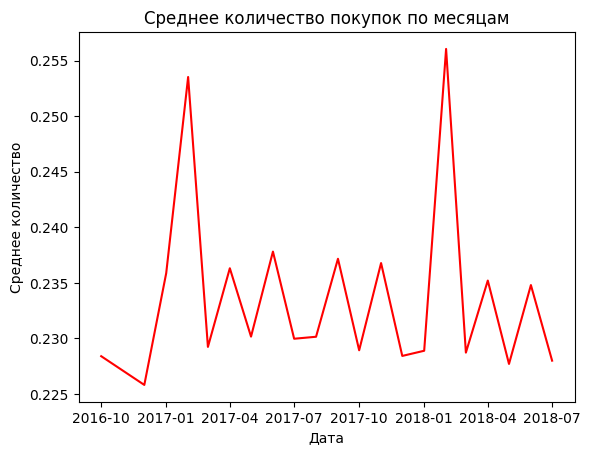

In [ ]:
# Сгруппируем данные по месяцам, посчитаем для каждого месяца среднее количество покупок в неделю:
ans = ans.groupby('month').agg({'avg_week_buy': 'mean'}).reset_index().sort_values('month')

# Построим график распределния, где по оси Х будет год и месяц, а по оси У - среднее количество покупок в неделю
plt.plot(ans['month'], ans['avg_week_buy'], color='red')
plt.xlabel('Дата')
plt.ylabel('Среднее количество')
plt.title('Среднее количество покупок по месяцам')

plt.show()

### **5) Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.**

In [ ]:
# Объединяем данные по индетификатору пользоватей:
table = order_table.merge(user_table, on='customer_id')

# Отбираем данные, берем в рассчет полный год (2017), а также 3 месяца после,
# так как нам нужно найти retention на 3-ий месяц:
table_full = table[table['order_purchase_timestamp'].astype('str') >= '2017-01-01'] \
 [table['order_purchase_timestamp'].astype('str') < '2018-04-01'][table['order_status'] != 'unavailable'][table['order_status'] != 'canceled']. \
 sort_values('order_purchase_timestamp', ascending=True)
table_full['month'] = table_full['order_purchase_timestamp'].dt.strftime('%Y-%m')

table_full.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_estimated_delivery_date,month,year,sort,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
78768,ec7a019261fce44180373d45b442d78f,c24fc5f9a446b4d8262041b9c64de772,delivered,2017-01-05 11:56:06,2017-01-05 12:10:17,2017-01-06 12:43:41,2017-01-11 13:14:05,2017-02-01 00:00:00,2017-02-01,2017-01,2017,2017-01-01,f7b981e8a280e455ac3cbe0d5d171bd1,80030,curitiba,PR
16201,b95a0a8bd30aece4e94e81f0591249d8,ff3c6d35b4927c9b965aa6a68dcf56e4,delivered,2017-01-05 12:01:20,2017-01-07 03:35:37,2017-01-11 16:22:53,2017-01-17 15:38:58,2017-02-13 00:00:00,2017-02-13,2017-01,2017,2017-01-01,83e7958a94bd7f74a9414d8782f87628,80030,curitiba,PR
74670,38bcb524e1c38c2c1b60600a80fc8999,d2c63ad286e3ca9dd69218008d61ff81,delivered,2017-01-05 12:06:36,2017-01-07 03:45:22,2017-01-11 15:35:54,2017-01-16 16:05:22,2017-02-13 00:00:00,2017-02-13,2017-01,2017,2017-01-01,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR
15352,7a18a504c1a4b32d883e68de2e1a7db0,e6bee29442c761ff0dfb9a4414922a5c,delivered,2017-01-05 12:09:08,2017-01-07 03:44:08,2017-01-11 15:35:53,2017-01-16 15:43:29,2017-02-13 00:00:00,2017-02-13,2017-01,2017,2017-01-01,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR
27002,6acecf438369055d9243e121045cca74,42d857e22f61f10476f0cda1aacc018a,delivered,2017-01-05 12:11:23,2017-01-07 03:44:07,2017-01-11 16:22:53,2017-01-17 16:06:30,2017-02-13 00:00:00,2017-02-13,2017-01,2017,2017-01-01,728e4a7d0db4845270091ded0923c71f,80540,curitiba,PR


In [ ]:
# Для каждого пользователя найдем дату первой покупки:
table = table_full.groupby('customer_unique_id', as_index=False).agg({'order_purchase_timestamp': 'min'}).reset_index().rename(columns={'order_purchase_timestamp': 'date'}).sort_values('customer_unique_id')
table['date'] = table['date'].dt.strftime('%Y-%m')

In [ ]:
# Соединяем таблицы, группируем по датам, таким образом создавая когорты по дате первой покупки:
cohorts = table_full[['customer_unique_id', 'order_id', 'month']].merge(table, on='customer_unique_id')
cohorts = cohorts.groupby(['date', 'month']).agg({'customer_unique_id': 'nunique'})

cohorts.head()

customer_unique_id
date    month                      
2017-01 2017-01                 753
        2017-02                   3
        2017-03                   2
        2017-04                   1
        2017-05                   3

In [ ]:
# Делаем функцию, которая будет индексировать месяцы внутри каждой когорты:
def index(line):
  line['month_index'] = np.arange(start=0, stop=len(line))
  return line

# Группируем по когортам, присваивая индексы:
cohorts = cohorts.groupby('date').apply(index)

cohorts.head()

customer_unique_id  month_index
date    month                                   
2017-01 2017-01                 753            0
        2017-02                   3            1
        2017-03                   2            2
        2017-04                   1            3
        2017-05                   3            4

In [ ]:
# Преобразовываем столбцы в индексы:
cohorts.reset_index(inplace=True)
cohorts.set_index(['date', 'month_index'], inplace=True)

# Сохраняем размер каждой когорты:
size = cohorts['customer_unique_id'].groupby('date').first()

# Формируем таблицу retention:
retention = cohorts['customer_unique_id'].unstack('date').T.divide(size, axis=0)

retention.head()

month_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13
date,,,,,,,,,,,,,,
2017-01,1.0,0.003984,0.002656,0.001328,0.003984,0.001328,0.003984,0.001328,0.001328,0.003984,0.001328,0.006640,0.003984,0.001328
2017-02,1.0,0.002367,0.002959,0.001183,0.004142,0.001183,0.002367,0.001775,0.001183,0.001775,0.001183,0.002959,0.001183,0.001775
2017-03,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,0.003890,0.001167,0.002334,NaN
2017-04,1.0,0.006019,0.002150,0.001720,0.003009,0.002580,0.003439,0.003009,0.003009,0.001720,0.002580,0.000860,NaN,NaN
2017-05,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,0.002542,0.002542,0.002542,NaN,NaN,NaN


### Визуализация таблицы retention:
Таким образом, можно сделать вывод, что когорта с наибольшим retention на 3-ий месяц в период с января по декабрь: 2017-05.

Text(97.25, 0.5, 'Когорта')

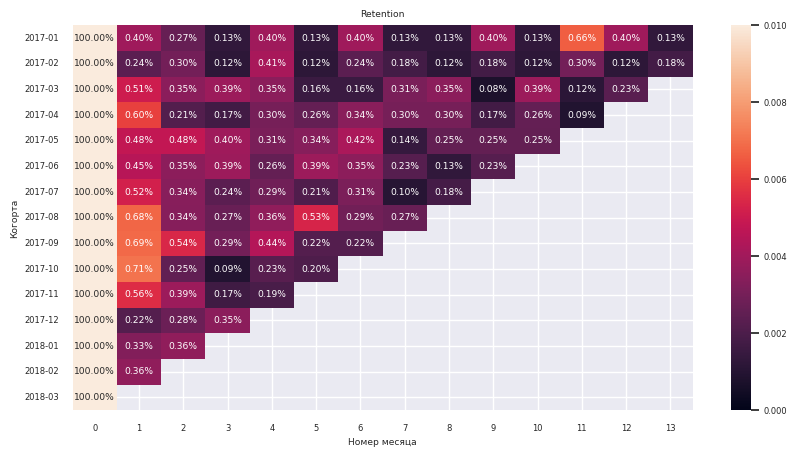

In [ ]:
sns.set(font_scale=0.55)
plt.figure(figsize=(10,5))
sns.heatmap(retention, mask=retention.isnull(), annot=True, fmt='.2%', vmin=0.00, vmax=0.01)
plt.title('Retention')
plt.xlabel('Номер месяца')
plt.ylabel('Когорта')